# Perform a simulation with a semi-empirical rudder model

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [168]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
#from vessel_manoeuvring_models.models.semiempirical_rudder import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.models.ModelSimulatorWithPropellerSemiempiricalRudder import ModelSimulatorWithPropellerSemiempiricalRudder
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
import inspect
from sympy.printing import pretty

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/01/23 09:12:01] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=740542;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=293669;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/01/23 09:12:02] INFO     Kedro project phd                                                      ]8;id=630708;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=318476;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=521836;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=388554;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=768949;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=67917;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=54523;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=371306;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=565110;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=374025;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=271204;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=104255;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=160753;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=930603;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=62808;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=99742;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=950994;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=519637;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model_slic = model_loader['SLIC_propeller']()

In [6]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [7]:
result_slic = model_slic.simulate(data)

## Simulation with the semi-empirical rudder model

In [35]:
rudder_particulars = {
'x_R'   : ship_data['x_r'],
'y_R'   : 0,
'z_R'   : 0,
'A_R'   : 70/(ship_data['scale_factor']**2),
'b_R'   : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f'   :ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}

rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(40),
"kappa": 0.5, # (Small value means much flow straightening)
}


In [36]:
ship_parameters = model_slic.ship_parameters.copy()
ship_parameters.update(rudder_particulars)
ship_parameters.update(prop_data)

In [53]:
model_slic.acceleration_lambda

<function _lambdifygenerated(I_z, Ndelta, Nr, Nrdot, Nthrust, Nthrustdelta, Nu, Nur, Nv, Nvdot, Nvvdelta, Xdeltadelta, Xrr, Xthrust, Xu, Xudot, Xuu, Xvr, Ydelta, Yr, Yrdot, Ythrust, Ythrustdelta, Yu, Yur, Yv, Yvdot, Yvvdelta, delta, m, r, thrust, u, v, x_G)>

In [155]:
parameters = dict(model_slic.parameters.copy())
parameters.update(rudder_parameters)
parameters['Ydelta']=0
parameters['Ythrustdelta']=0

model_semiempirical_rudder = ModelSimulatorWithPropellerSemiempiricalRudder(simulator=model_slic, 
                                                   parameters=parameters, 
                                                   ship_parameters=ship_parameters, 
                                                   prime_system=model_slic.prime_system, 
                                                   lambda_thrust=model_slic.lambda_thrust)
model_semiempirical_rudder.parameters = parameters

In [157]:
model_semiempirical_rudder.X_eq

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [161]:
model_semiempirical_rudder.X_qs_eq

Eq(X_D(u, v, r, delta, thrust), X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [170]:
X_qs = sp.symbols("X_qs")
model_semiempirical_rudder.X_eq.subs(model_semiempirical_rudder.X_qs_eq.rhs,X_qs)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_qs + X_{\dot{u}}*\dot{u})

In [171]:
X_qs = sp.symbols("X_qs")
print(model_semiempirical_rudder.X_eq.subs(model_semiempirical_rudder.X_qs_eq.rhs,X_qs))

Eq(m*(\dot{u} - r**2*x_G - r*v), X_qs + X_{\dot{u}}*\dot{u})


In [156]:
result_semiempirical_rudder = model_semiempirical_rudder.simulate(data)

hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej
hej


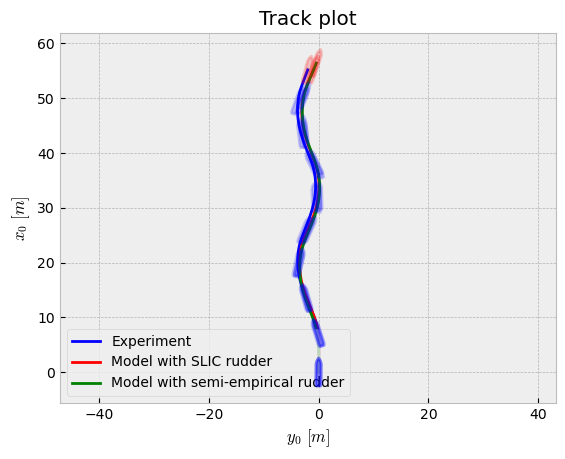

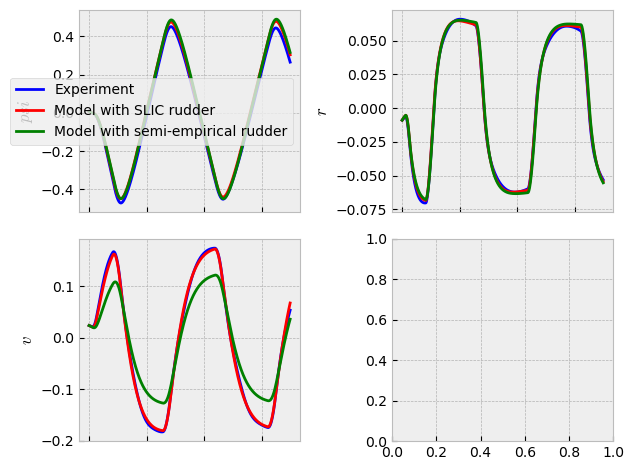

In [154]:
dataframes = {'Experiment':data,
              'Model with SLIC rudder':result_slic.result,
              'Model with semi-empirical rudder':result_semiempirical_rudder.result,
              
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes=dataframes, keys=['v','r','psi']);

In [147]:
inputs={}
df_result = result_semiempirical_rudder.result.copy()
states_dict=df_result
U_=df_result['U']
control = df_result[model_semiempirical_rudder.control_keys]
model_semiempirical_rudder.calculate_rudder_Y_force(inputs=inputs, states_dict=states_dict, control=control, U=U_)

0.000000    -1.283741
0.010000    -1.280610
0.020000    -1.277212
0.030000    -1.273820
0.040000    -1.270436
               ...   
69.780004    5.775339
69.790004    5.771474
69.800004    5.767329
69.810004    5.762904
69.820004    5.759082
Length: 6983, dtype: float64

In [148]:
import vessel_manoeuvring_models.models.semiempirical_rudder as semiempirical_rudder

In [149]:
self = model_semiempirical_rudder
states_dict=df_result
U=df_result['U']
control = df_result[model_semiempirical_rudder.control_keys]

V_x = run(
    function=semiempirical_rudder.lambdas_propeller[semiempirical_rudder.V_x],
    inputs=states_dict,
    **self.ship_parameters,
    **control,
)

fy_rudders_SI = run(
            function=semiempirical_rudder.lambdas_lift[Y_R],
            inputs=states_dict,
            V_x=V_x,
            C_L_tune=self.parameters["C_L_tune"],
            delta_lim=self.parameters["delta_lim"],
            kappa=self.parameters["kappa"],
            **inputs,
            **self.ship_parameters,
            **control,
        )  # (SI)

In [151]:
fy_rudders_SI

0.000000    -1.283741
0.010000    -1.280610
0.020000    -1.277212
0.030000    -1.273820
0.040000    -1.270436
               ...   
69.780004    5.775339
69.790004    5.771474
69.800004    5.767329
69.810004    5.762904
69.820004    5.759082
Length: 6983, dtype: float64

<Axes: >

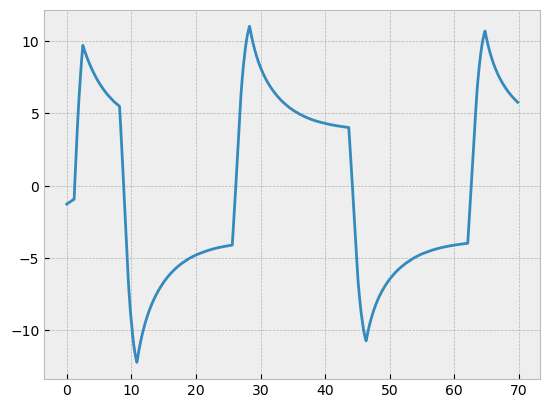

In [136]:
fy_rudders_SI.plot()

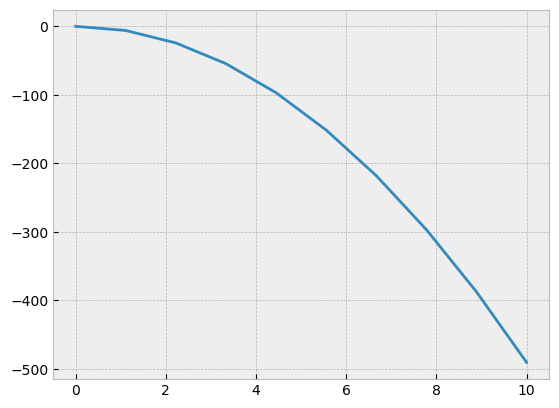

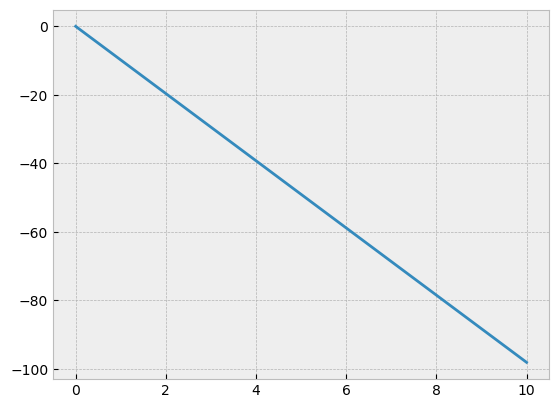

In [95]:
fig,ax=plt.subplots()
ax.plot(result.t, result.y[0,:])
fig,ax=plt.subplots()
ax.plot(result.t, result.y[1,:])